# Regression
[![Run in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bobmh43/handson_ml/blob/master/notebooks/ch4_regression.ipynb)

5. As you use GD to train your model, if both training error and validation error are increasing, the learning rate is too high and the model is diverging (leaving the global minimum). If only the validation error is increasing, the model is overfitting. You should do early stopping.

In [ ]:
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt

In [ ]:
# Play data 1: Linear
np.random.seed(42)
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

In [ ]:
# OLS using the Moore-Penrose Inverse
model = LinearRegression()
model.fit(X, y) #no need to add dummy feature
X_new = np.array([[0], [2]])
print(model.predict(X_new))
print("Estimated equation: " + f"y = {model.intercept_[0]} + {model.coef_[0, 0]} * x")

[[4.21509616]
 [9.75532293]]
Estimated equation: y = 4.215096157546747 + 2.7701133864384837 * x


In [ ]:
# Ordinary Linear Regression using Stochastic Gradient Descent
model1 = SGDRegressor(penalty=None, n_iter_no_change=100, random_state=42)
model1.fit(X, y.ravel())
print(model1.predict(X_new))
print("Estimated equation: " + f"y = {model1.intercept_[0]} + {model1.coef_[0]} * x")

[4.15474433 9.80603508]
Estimated equation: y = 4.1547443263332395 + 2.8256453776562838 * x


In [ ]:
# simulate mini-batch gradient descent (approximately) by using SGDRegressors's partial_fit()
model_mb = SGDRegressor(penalty=None, n_iter_no_change=100, random_state=42)
n_epoch = 80
m = 100
minibatch_size = 10
n_iter_per_epoch = m // minibatch_size
for e in range(n_epoch):
  shuffled_indices = np.random.permutation(m)
  X_shuffled = X[shuffled_indices]
  y_shuffled = y[shuffled_indices]
  for i in range(n_iter_per_epoch):
    X_minibatch = X_shuffled[i * minibatch_size : (i + 1) * minibatch_size]
    y_minibatch = y_shuffled[i * minibatch_size : (i + 1) * minibatch_size]
    model_mb.partial_fit(X_minibatch, y_minibatch.ravel())
print(model_mb.predict(X_new))
print("Estimated equation: " + f"y = {model_mb.intercept_[0]} + {model_mb.coef_[0]} * x")

[4.06525942 9.86984644]
Estimated equation: y = 4.065259419683589 + 2.902293512526511 * x


In [ ]:
# Play data 2: Quadratic:
#np.random.seed(42)
m = 100
X2 = 6 * np.random.rand(m,1) - 3 # column vector
y2 = 0.5 * X2**2 + X2 + 2 + np.random.randn(m, 1)
X2_val = 6 * np.random.rand(m,1) - 3 # column vector
y2_val = 0.5 * X2_val**2 + X2_val + 2 + np.random.randn(m, 1)

In [ ]:
# Polynomial regression
polynomial_regression = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                                      StandardScaler(),
                                      SGDRegressor(penalty=None, tol=1e-5, random_state=42))
polynomial_regression.fit(X2, y2.ravel())
print(polynomial_regression[2].intercept_, polynomial_regression[2].coef_)
polynomial_regression.predict(X_new)

[3.41404232] [1.65830832 1.50756646]


array([1.78239688, 5.90802874])

In [ ]:
# Learning curve comparison
def display_learning_curve(estimator, X, y, title):
  train_sizes, train_scores, val_scores = learning_curve(estimator,
                                                        X, y, train_sizes=np.linspace(0.01, 1.0, 40),
                                                        cv=5, scoring="neg_root_mean_squared_error")
  train_RMSE = np.mean(-train_scores, axis=1)
  val_RMSE = np.mean(-val_scores, axis=1)

  plt.figure(figsize=(6, 4))
  plt.plot(train_sizes, train_RMSE, "r-+", linewidth=2, label="train")
  plt.plot(train_sizes, val_RMSE, "b-", linewidth=3, label="valid")

  plt.title(title)
  plt.xlabel("Training set size")
  plt.ylabel("RMSE")
  plt.grid()
  plt.legend(loc="upper right")
  plt.axis([0, 80, 0, 2.5])
  plt.show()

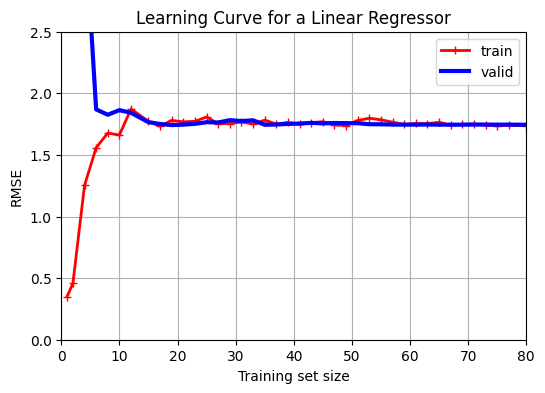

In [ ]:
display_learning_curve(SGDRegressor(penalty=None, n_iter_no_change=100, random_state=42), X2, y2.ravel(), "Learning Curve for a Linear Regressor")

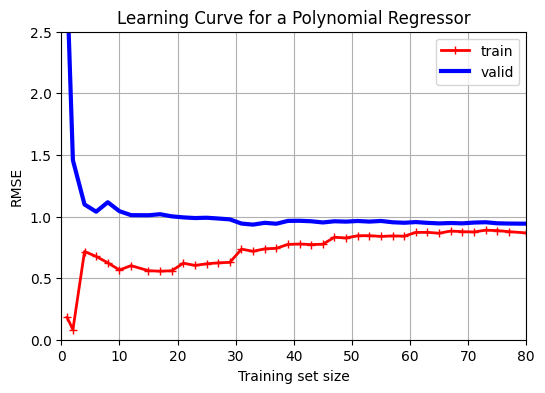

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning)
  display_learning_curve(make_pipeline(PolynomialFeatures(degree=4, include_bias=False),
                                        StandardScaler(),
                                        SGDRegressor(penalty=None, tol=1e-5, random_state=42)),
                        X2, y2.ravel(), "Learning Curve for a Polynomial Regressor of Degree 4")

In [ ]:
# Early stopping
poly_90 = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                        StandardScaler(),
                        SGDRegressor(max_iter=1000, penalty=None, eta0=0.002,
                                     early_stopping=True, tol=1e-3, n_iter_no_change=100,
                                     random_state=42))
poly_90.fit(X2, y2.ravel())
poly_90[2].n_iter_

302

In [ ]:
# Regularized models. We use the specialized estimators `Ridge`, `Lasso` and `ElasticNet` for their better training algorithms
def train_regularized_poly_regressor(estimator, X_train, y_train, X_val, y_val):
  model_reg = make_pipeline(PolynomialFeatures(degree=10, include_bias=False),
                            StandardScaler(),
                            estimator)
  model_reg.fit(X_train, y_train)
  print(estimator.__class__.__name__)
  print("model coefficients: ", model_reg[2].intercept_[0], *model_reg[2].coef_)
  # print("training R^2:", model_reg.score(X_train, y_train))
  # print("validation R^2:", model_reg.score(X_val, y_val))
  print("training MSE:", mean_squared_error(y_train.ravel(), model_reg.predict(X_train)))
  print("validation MSE:", mean_squared_error(y_val.ravel(), model_reg.predict(X_val)))
  print()

estimator_list = [Ridge(alpha=1.0, solver="svd"), Ridge(alpha=1.0, solver="saga", random_state=42),
                  Lasso(alpha=0.1, random_state=42), Lasso(alpha=1, random_state=42),
                  ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42), ElasticNet(l1_ratio=0.1, random_state=42), ElasticNet(l1_ratio=0.5, random_state=42),
                  LinearRegression(), SGDRegressor(penalty=None, tol=1e-5, random_state=42)]
_ = [train_regularized_poly_regressor(est, X2, y2, X2_val, y2_val) for est in estimator_list]

Ridge
model coefficients:  4.021076143384025 0.8906053569301031 1.1458335920553353 0.8477839330515644 0.41969592212047835 0.6193361887258996 0.08442891383892619 0.04382660761822539 -0.0939275750953022 -0.5749977373784674 -0.15733857606496368
training MSE: 0.9367520747539975
validation MSE: 1.369828188466335

Ridge
model coefficients:  4.021076143384025 0.8886590236490534 1.142716018575044 0.8600968099091834 0.4231217381135155 0.6051450002421676 0.08707528736123317 0.036656089686282284 -0.09272342722514566 -0.563684812031432 -0.16194664000443112
training MSE: 0.9369166526597907
validation MSE: 1.3696447070453104

Lasso
model coefficients:  4.021076143384025 0.9765783016042049 1.334245089560771 0.8145107486112743 0.0 0.0 0.0 0.0 0.0 0.0 0.0
training MSE: 0.9753182237546371
validation MSE: 1.4216762835144612

Lasso
model coefficients:  4.0210761433840245 0.234843074688639 0.5752435461383276 0.7940990914648979 0.0 0.0 0.0 0.0 0.0 0.0 0.0
training MSE: 2.6484104355538824
validation MSE: 3.1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
X, y = sklearn.datasets.load_iris(return_X_y=True)

In [ ]:
# iris dataset
X, y = sklearn.datasets.load_iris(return_X_y=True)

# logistic regression: Iris Virginica or not, based on just petal width
X = X[:, 3:]
y = y == 2
test_size = round(0.2 * y.shape[0])
shuffled_indices = np.random.permutation(y.shape[0])
test_indices = shuffled_indices[ : test_size]
train_indices = shuffled_indices[test_size : ]
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]

logistic_reg = LogisticRegression(penalty=None, random_state=42)
logistic_reg.fit(X_train, y_train)
print("training accuracy: ", logistic_reg.score(X_train, y_train))
print("validation accuracy: ", logistic_reg.score(X_test, y_test))

training accuracy:  0.9666666666666667
validation accuracy:  0.9333333333333333


In [ ]:
# softmax regression
X, y = sklearn.datasets.load_iris(return_X_y=True)
X = X[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)
print("training accuracy: ", softmax_reg.score(X_train, y_train))
print("validation accuracy: ", softmax_reg.score(X_test, y_test))

training accuracy:  0.95
validation accuracy:  0.98


Concepts:
- General: Model, Training Algorithm, Cost function, Gradient of cost function
- Specifics: Linear regression, normal equation, gradient descent (batch, stochastic, mini-batch), learning schedule; Polynomial regression; Learning curves and early stopping; Regularization: ridge, LASSO, Elastic Net; Logistic regression, log loss, Softmax regression, Cross Entropy
- Important recall questions:
    - Equations for all models and cost function gradients.
    - Which types of gradient descent don't converge? What do they need to converge?
    - Explain why polynomial regression is done using linear regression.
    - Explain how overfitting and underfitting relate to model bias and variance. How can we see these from a learning curve? (Side question: how do training-size- and iterations- learning curves differ in the trend of their training errors?)
    - What is the problem and the solutions if ...
        - both training and validation errors are going up as you perform more epochs? (Learning rate!)
        - the validation error is significantly higher than the training error or is increasing over time? (overfitting)
        - the training and validation error are pretty high? (underfitting)
    - When do we use ridge, Lasso and Elastic Net regularizations, respectively?
    - What is one preprocessing step I need to remember and why? (StandardScaler, because GD needs it, regularizations need it, etc.)
    - Explain as clearly as possible how softmax regression works? (scores, exponentiation, normalization). It is a generalization of logistic regression.

- Computational complexity of the Normal Equation vs SGD:
    - The normal equation scales poorly with the number of features.
    - The Batch GD algorithm scales poorly with the number of instances.

**Estimators**:
- `LinearRegression()`
- `SGDRegressor()`:
    - init parameters:
        - `max_iter`: actually epochs
        - `learning_rate`, `eta0`, `power_t`
        - `penalty`
        - `early_stopping`: If set to True, it will set aside `validation_fraction` of the training data as validation and terminate when the coef of det score on the validation data does not *improve* by at least `tol` for `n_iter_no_change` consecutive epochs. If set to False, but `tol` is not set to `None`, then actual early stopping still happens, but is done based on the nondecrease of the *training loss*.
        - `tol`
        - warm_start
    - remember to do StandardScaler() first
    - fit() takes y.ravel() (1d array)
- `LogisticRegression`: for logistic and softmax regressions

Note about estimators: they define parts of the model (eg. a linear model), and also all of the training algorithm. They do not contain info about the # of features at initialization. THey only get that during fitting.

**Transformers**:
- `PolynomialFeatures()`

Note about transformers: they may need to fit to the data. For example, when you create an instance of `PolynomialFeatures`, you only tell it the degree up to which you want combinations of. It still needs to know how many features it is dealing with and that comes from `fit(X)` or the fit part of `fit_transform(X)`, which store the information in the transformer.

**Model selection/evaluation**:
- `learning_curve()`: scores vs training size (+ cv)
    - For each training size in `train_size`, for each fold in a `cv`-fold cross validation split of the data, shrinks the training split by the factor specified by training size and trains the model on that before giving the training and validation scores (`scoring`).
    - Returns `train_sizes`, `train_scores` (shape= (n_ticks, n_cv_folds)), `val_scores` (shape=(n_ticks, n_cv_folds))

Hands-On Outline:
- Ordinary linear regression.
    - Closed form solution: `LinearRegression`
    - Gradient Descent: BGD, SGD, mBGD
        - `StandardScaler` + `SGDClassifier`
- Polynomial : `PolynomialFeatures` + `StandardScaler` + LR

- Learning curves
- Early stopping `SGDREgressor`'s `early_stopping` parameter
- Regularization:
    - l2, l1, elastic net:
        - l2:
            - closed form: `Ridge` using the `SVD` or `cholesky` solver
            - iterative: `SGDRegressor` with penalty, or better, `Ridge` using the `saga` solver.
        - l1: `SGDRegressor` with penalty or better `Lasso` (uses coordinate descent)
        - elastic net: `SGDRegressor` with penalty or better `ElasticNet` (uses coordinate descent)
- Logistic regression
- Softmax regression
